# Цель Проекта 
Нам дан файл с комментариями с Твитера. Они помеченны как позитивные/негативные. Нам требуется построить NLP модель которая сможет предсказать токсичность комментариев с минимальной оценкой 0.75 по F1 Score.


<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV3</b></font>

    
    
Привет Владислав! Получил совершенно другую работу, без своих комментариев.  Как это понимать? Это ошибка, или ты решил начать проект по новой?  Чтобы не терять времени, все таки посмотрел твой проект,  выделив очевидные ошибки, начав как будто с первой итерации

# План Проекта
1. Цель Проекта
2. План Проекта
3. Библеотеки/Выгрузка Данных
4. Исследовательский Анализ
5. Предобработка Данных 
6. Перебор Гиперпараметров
7. Тестированые Лучшей Модели
8. Вывод

# Библеотеки/Выгрузка Данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import re
import os
import random

from langdetect import detect
from collections import Counter

import nltk
import spacy
import wordcloud

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

In [2]:
random.seed(42)

In [3]:
local_path = './datasets/toxic_comments.csv'
web_path = '/datasets/toxic_comments.csv'

if os.path.exists(local_path):
  df = pd.read_csv(local_path, index_col=0)
elif os.path.exists(web_path):
  df = pd.read_csv(web_path, index_col=0)

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


# Исследовательский Анализ

- Хорошая ссылка
- Exploritory Data Analysis for NLP
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


<Axes: >

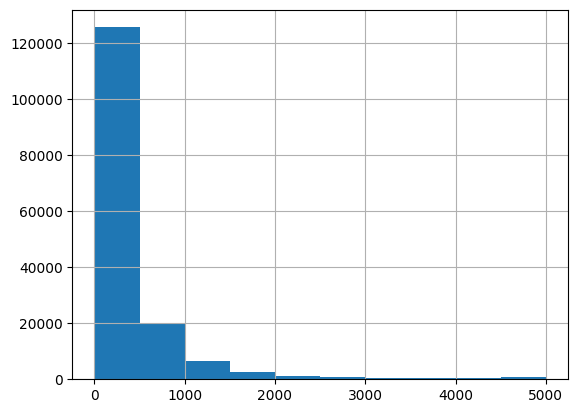

In [6]:
df.text.str.len().hist()

По графику видно что большинство текстов короче 3000 символов. Можно будет удалить лишние данные и оптимизировать обучение.

<Axes: >

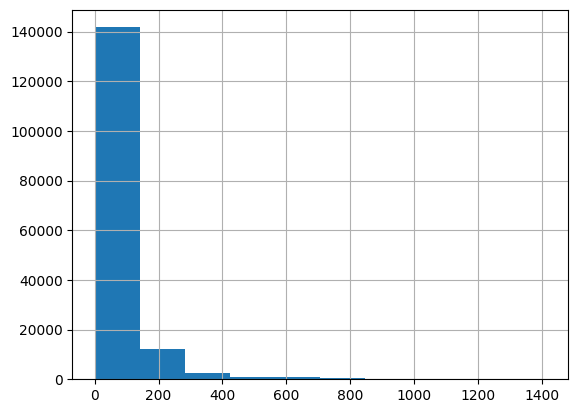

In [7]:
df.text.str.split().map(lambda x: len(x)).hist()

По графику видно что большинство текстов состоят из меньше чем 500 слов.

<Axes: >

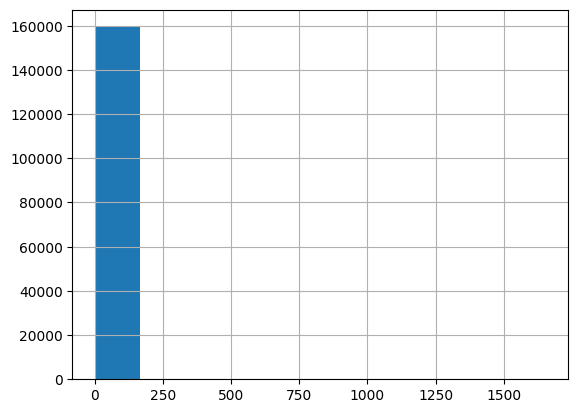

In [8]:
df.text.str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

По этому графику видно что длина слов иммеет выбросы в данных.

In [9]:
def safe_detect(text):
    try:
        return detect(text)
    except:
        return '--'

languages = df.text.sample(1000).apply(lambda x: safe_detect(x))
unique_languages = languages.unique()

print("Languages found in dataframe:")
print(unique_languages)

Languages found in dataframe:
['en' 'hu' 'cy' 'no' 'tr' 'nl' 'tl' 'sv' 'et' 'it' 'de' 'fr' 'da' 'sl'
 'so' 'pt' 'af']


Наблюдается большое количество разных языков.

<Axes: >

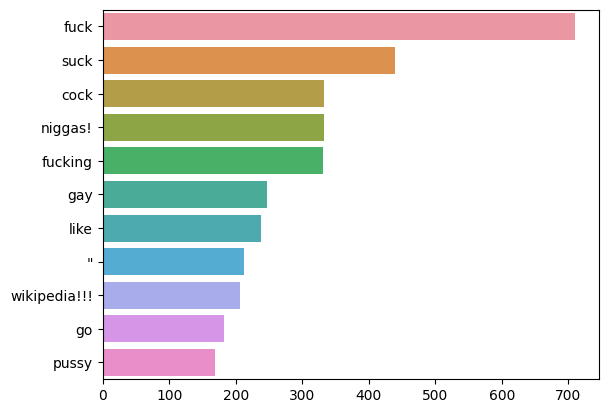

In [10]:
stop = set(nltk.corpus.stopwords.words('english'))

counter_toxic = Counter(
    np.concatenate(
        df[df.toxic == 1].text\
            .sample(1000).str.lower()\
                .str.split().values))
most = counter_toxic.most_common()

x, y = [], []
for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)
sns.barplot(x=y, y=x)

# Предобработка данных

- Полезная статья https://www.datacamp.com/tutorial/stemming-lemmatization-python

- Побробуем самый простой вариант обработки текста.
  - Удалим все знаки.
  - Проведем токенизацию.
  - Проведем лемматизацию.
  - Вконце создадим мешек слов.

In [11]:
pattern_numbers_characters = r'[\d\W]'
df['text'] = df['text'].str.lower().str.replace(pattern_numbers_characters, ' ', regex=True)

In [12]:
df.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m s...,0
2,hey man i m really not trying to edit war it...,0
3,more i can t make any real suggestions on im...,0
4,you sir are my hero any chance you remember...,0


In [13]:
nlp = spacy.load('en_core_web_sm')
def lemma_clear(text): 
      
    lemm = nlp(text) 
    lemm = " ".join([token.lemma_ for token in lemm])  
    return " ".join(lemm.split())

In [14]:
%%time

df['text'] = df['text'].apply(lambda x: lemma_clear(x))

CPU times: user 37min 31s, sys: 32.4 s, total: 38min 3s
Wall time: 38min 8s


<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Успех 👍:



Принято




</div>


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:



- WordNetLemmatizer  рабочий вариант, но у него есть особенности, для корректной работы ему нужно передавать не просто слово, но и POS-тег (Part of Speech, части речи). Набираемся ума-разума [тут](https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/) )  Обрати внимание на функцию `get_wordnet_pos`. Сразу хочу предупредить, что если делать Лемматизацию правильно, сучетом постегов, то время может занять полчаса-час. Так что не удивляйся


Лемматизацию можно было сделать с помощью SpaCy лемматизатором и прямо скажем как инструмент он более удобен и универсален, можно поподробней тут [почитать](https://habr.com/ru/post/531940/). Ниже помог кодом  



<div class="alert alert-warning">


Совет: 








- попробуй .progress_apply, делает что .apply, но еще и показывает на какой итерации находится


  
- после очистки и лемитизации можно провести частотный анализ текста/[облако слов](https://habr.com/ru/post/517410/) - чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных твитах Кроме того графики, рисунки делают проект визуально интересней


В тренажере облако импортируем так

    !/opt/conda/bin/python -m pip install wordcloud
    
      

- когда что то долго крутиться, можно использовать  %%time - ставишь на самый вверх ячейки с кодом, время выполнения которого хочешь замерить, может не знаешь.  Быстрее не станет, но все будут видеть стоит ли ждать не отходя от ПК или можно сходить чаек поставить ))  




In [15]:
train, test = train_test_split(df, test_size=0.4)

In [16]:
test, valid = train_test_split(test, test_size=0.5)

# Перебор Гиперпараметров

In [17]:
%%time

params={'model__C':[.01,.05,.1,.5,1,5,10],
           'model__penalty':['l2']}
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4))),
    ('tfidf', TfidfTransformer()),
    ('model', LogisticRegression(max_iter=1000))])
grid_lr = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1')
grid_lr.fit(train['text'], train['toxic'])
grid_lr.score(valid['text'], valid['toxic'])

CPU times: user 29.1 s, sys: 2.6 s, total: 31.7 s
Wall time: 4min 36s


0.7776427703523694

<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Ошибка:

Отличная работа, использование связки GridSearch + pipeline это уже другой уровень. Но test датасет используем в самом конце, когда тестируем лучшую модель. Лучшую модель выбираем по .best_score_ 




In [18]:
%%time

params={'model__n_estimators': [50, 100], 'model__max_depth': [50, 100]}
pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=40, ngram_range=(1,4))),
    ('tfidf', TfidfTransformer()),
    ('model', RandomForestClassifier())])
grid_rfc = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1')
grid_rfc.fit(train['text'], train['toxic'])
grid_rfc.score(valid['text'], valid['toxic'])

CPU times: user 49.2 s, sys: 1.73 s, total: 50.9 s
Wall time: 4min 18s


0.5719903867161897

# Тестированые Лучшей Модели

In [19]:
z_test = grid_lr.predict(test['text'])
f1_score(test['toxic'], z_test)

0.7762321827236821




<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>

Ошибка:

А вот тут, в самом конце,  выбрав лучшую модель на валидации, проверяем ее на тестовом датасете - делаем финальное тестирование. И если лучшая модель выбранная на валидационной покажет на test результат хуже требуемого, мы начнем процесс моделирования сначала (а не будем такие - "а давай попробуем на тесте модель которая на валидации не была лучшей, может она нам на test даст нужное качество").         
    
Почему только лучшая?! Это делается для того, чтобы мы даже незначительным образом не "подгонялись" под тестовую выборку. Ведь на train модели обучаются, по валидиации подгоняются гиперпараметры. Эти данные модели "знают". А test (out-of-sample) это уже моделирование прогноза на реальных данных и ситуации когда у нас есть уже лучшая модель (в рельности у нас же не может быть несоклько прогнозов, что то в любом случаи надо выбирать). Вот поэтому такая двухуровневая проверка на подгонку. Кроме того использование мноих моделей с разными гиперпараметрами это тоже подгонка, поэтому выбирая одну и тестируя только ее, мы тем самым боремся с подгонкой через использование многих-многих моделей, когда результат хорош не потому что мы данные почистили хорошо, моделировали правильно итд итп, а потому что из многих моделей хоть какая то случайно "сыграет". 


# Вывод

Спасибо за детальные комментарии по проекту. Мне кажется что по хорошему надо было сразу делать проект с ручным трансформированыем данных, не прыгать выше головы с Бертом.

<div class="alert alert-warning">
<font size="5"><b>Комментарий ревьюераV2</b></font>



Совет 🤔:



Ты мог использовать код из тренажёра, на самом деле в каком-то смысле Берт реализовать проще


<div class="alert alert-danger">
<font size="5"><b>Комментарий ревьюера</b></font>



Ошибка:    

Во-первых


Не забываем при инициализации модели о random_state, иначе после каждого запуска кода у нас может быть разный результат

    
Во-вторых    
    
Всё-таки стоит поперебирать гиперпараметры
    
Есть два варианта исправить красное:
    
    
1. Создать валидационный датасет, и по нему подобрать лучшие гиперпараметры в вручную написанном цикле 
    
    
2.  Можно вместо цикла использовать sklearn-ий встроенный функционал GridSearch. В случаи использования GridSearch, не нужно будет заранее делать валидационную выборку, лучшую метрику автоматом сохранят в best_score_, а лучшую модель (переобученная уже на полном наборе данных) будет хранить в best_estimator_, данные обучения положит в cv_restult_. А главное  он сделает несколько разбиений на train / validation выборки (кросс-валидация), тем самым поборется с рандомом, когда на валидации получен хороший результат только изза удачного сплита. 

А еще лучше использовать связку GridSearchCV + pipeline. 

[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), это тема которая сразу затрагивает кроссвалидацию, тюнинг "векторайз", подбор гиперпараметров модели и о том что код стоит делать компактным.
    
    
- в TfidfVectorizer(stop_words=stopwords) у тебя по умолчанию ngram_range=(1, 1), тут можно подбирать разное число n- грамм (и другие параметры), максимизируя метрику, но как объединить перебор по ngram_range с обучением моделей, чтобы не делать это по отдельности или с использованием цикла?! pipeline! Готовый [пример для работы с текстами](https://medium.com/@yoni.levine/how-to-grid-search-with-a-pipeline-93147835d916). Всё что нужно там есть, хотя очень лаконично. Можешь погуглить по:


    
    pipeline nlp gridsearchcv
    
    
- как избежать ошибки подглядывания в будущее, когда мы предварительно работаем с данными (шкалирование, нормализация, TfidfVectorizer итп итд)? pipeline! особенно это важно, когда мы используем кроссвалидацию. Для TfidfVectorizer делаеь .fit (обучаемся) на train, а transform на test, точно также нужно сделать для валидационной выборки. Но GS делает валидационные внутри себя, спрашивается как добраться до них и избежать подглядывания в будущее? Казалось бы никак, но нет! Pipeline! ) 
    
    
- pipeline позволяет делать наш код компактней и читабельней, это большой плюс, когда код будет раздуваться   



В общем если сделать GS+pieline будет вообще хорошо )  
    
    
    
и только затем, выбрав лучшую модель (с лучшими значениями гиперпараметров) проведем тестирование на датасете о котором наша модель не имеет никакого представления. И если окажется что тестовая метрика (нашей лучшей на валидации модели) не удовлетворяет критериям качества, то мы начнем процесс моделирования с начала (а не будем пробовать другие модели которые были хуже на валидации - по приниципу "а вдруг другая модель подойдет").    
    
    


</div>



<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюера</b></font>


    
    
    


Обязательное к исправлению:






- WordNetLemmatizer используем с POS - тег 

    
    
    

- при инициализации модели не забываем random_state (можно один раз вначале просто прописать random.seed(42), чтобы не прописывать каждый раз везде random_state. Кстати знаешь откуда 42?)



- нет перебора гиперпараметров (это можно сделать с помощью вручную прописанных циклов либо с помощью GridSearchCV)

    
    
    
Жду исправлений, для принятия проекта. Если какие то вопросы, то сразу спрашивай ) 


<font color='green'><b>Полезные (и просто интересные) материалы:</b> \
Для работы с текстами используют и другие подходы. Например, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.\
https://huggingface.co/transformers/model_doc/bert.html \
https://t.me/renat_alimbekov \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
https://transformer.huggingface.co/ - поболтать с трансформером \
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множествореализованных
методов для трансформеров методов NLP \
Word2Vec https://radimrehurek.com/gensim/models/word2vec.html 


Если понравилась работа с текстами, то можешь посмотреть очень интересный (но очень-очень сложный) курс лекций: https://github.com/yandexdataschool/nlp_course .

Если нравится смотреть и слушать то есть целый курс на Ютубе https://www.youtube.com/watch?v=qDMwIQRQt-M&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=1



<div class="alert alert-info">
<font size="5"><b>Комментарий ревьюераV2</b></font>

Спасибо за работу!    


- на test датасете тестируем только лучшую модель (нарушена логика использования датасетов при моделировании)

